In [6]:
# retrieve the ISIC dataset stuff
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Input.zip
!unzip ISIC_2024_Training_Input.zip

!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_Supplement.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2024/ISIC_2024_Training_GroundTruth.csv

Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "unzip" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [ ]:
# params
FREEZE = True # whether or not to freeze the weights
EPOCHS = 10 # number of training epochs
DUPE = True
#TRAIN_DIR = 'C:\\Users\\rngki\\Downloads\\train_images_hair_removed_dullrazor\\'
TRAIN_CSV = 'C:\\Users\\rngki\\Downloads\\train_dataset_with_skin_tone.csv'
TRAIN_DIR = './ISIC_2024_Training_Input/'
#TRAIN_CSV = 'C:\\Users\\rngki\\Downloads\\train-metadata.csv'
#TRAIN_CSV = 'C:\\Users\\rngki\\Downloads\\cleaned_styled_data\\cleaned_styled_data\\cleaned_augmented_data.csv'
#TEST_DIR = 'C:\\Users\\rngki\\Downloads\\test_images_hair_removed_dullrazor\\'
#TEST_CSV = 'C:\\Users\\rngki\\Downloads\\test_dataset_with_skin_tone.csv'
TEST_DIR = './ISIC_2024_Training_Input/'
TEST_CSV = 'C:\\Users\\rngki\\Downloads\\test_dataset_with_skin_tone.csv'
#TEST_DIR = ''
#TEST_CSV = '' 

USE_SPLIT = False

MALIGNANT = 'target'
# MALIGNANT = 'target'
MALIG_IDX = 1
# MALIG_IDX = 3

if not TEST_DIR:
    TEST_DIR = TRAIN_DIR
    USE_SPLIT = True
if not TEST_CSV:
    TEST_CSV = TRAIN_CSV
    USE_SPLIT = True

In [54]:
# setup the model to be transfer learned
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split


In [88]:

if USE_SPLIT:
    df = pd.read_csv(TRAIN_CSV)
    #df = pd.read_csv('C:\\Users\\rngki\\Downloads\\cleaned_styled_data\\cleaned_styled_data\\cleaned_augmented_data.csv')
    print(f"num malignant: {sum(df[MALIGNANT])}")

    # downsample for time
    df = df.sample(frac=.1, random_state=42)

    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df[MALIGNANT], random_state=42)
else:
    train_df = pd.read_csv(TRAIN_CSV)
    val_df = pd.read_csv(TEST_CSV)

if DUPE:
    malig_df = train_df[train_df[MALIGNANT] == 1]
    malig_df = pd.concat([malig_df]*100, ignore_index=True)

    train_df = pd.concat([train_df, malig_df], ignore_index=True)

    #malig_df = val_df[val_df['malignant'] == 1]
    #malig_df = pd.concat([malig_df]*100, ignore_index=True)

    #val_df = pd.concat([val_df, malig_df], ignore_index=True)


def balance_classes(df, label_col=MALIGNANT):
    # Separate malignant and non-malignant samples
    malig_df = df[df[label_col] == 1]
    non_malig_df = df[df[label_col] == 0]

    # Get the minority count
    min_count = min(len(malig_df), len(non_malig_df))

    # Downsample both classes to min_count (or oversample malignant if needed)
    non_malig_df_balanced = non_malig_df.sample(n=min_count, random_state=42)
    malig_df_balanced = malig_df.sample(n=min_count, replace=True, random_state=42)  # oversample if needed

    # Concatenate back
    balanced_df = pd.concat([malig_df_balanced, non_malig_df_balanced]).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_df

# Balance the training set
train_df = balance_classes(train_df)

train_df.to_csv('train_labels.csv', index=False)
val_df.to_csv('val_labels.csv', index=False)

print(f"Validation - Num malignant: {val_df[MALIGNANT].sum()}")
print(f"Validation - Num benign: {len(val_df) - val_df[MALIGNANT].sum()}")
print(f"Training - Num malignant: {train_df[MALIGNANT].sum()}")
print(f"Training - Num benign: {len(train_df) - train_df[MALIGNANT].sum()}")

class ISICDataset(Dataset):
    def __init__(self, csv_file, img_dir, non_malignant_transform=None, malignant_transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.non_malignant_transform = non_malignant_transform
        self.malignant_transform = malignant_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0] + '.jpg')

        image = Image.open(img_path).convert('RGB')

        if self.df.iloc[idx, MALIG_IDX] == 0 and self.non_malignant_transform:
            image = self.non_malignant_transform(image)
        elif self.df.iloc[idx, MALIG_IDX] == 1 and self.malignant_transform:
            image = self.malignant_transform(image)

        return image, int(self.df.iloc[idx, MALIG_IDX]), self.df.iloc[idx, 0]



transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])

malignant_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=30),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = ISICDataset(
    csv_file='val_labels.csv',
    img_dir=TEST_DIR,
    non_malignant_transform=transform,
    malignant_transform=transform
)

train_dataset = ISICDataset(
    csv_file='train_labels.csv',
    img_dir=TRAIN_DIR,
    non_malignant_transform=transform,
    malignant_transform=malignant_transform
)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"Training set size: {len(dataloader.dataset)}")
print(f"Validation set size: {len(valloader.dataset)}")
#malig = sum([x[1] for x in dataloader.dataset])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {'cuda' if torch.cuda.is_available() else 'cpu'}")


C:\Users\rngki\AppData\Local\Temp\ipykernel_73904\888517920.py:11: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_CSV)
C:\Users\rngki\AppData\Local\Temp\ipykernel_73904\888517920.py:12: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  val_df = pd.read_csv(TEST_CSV)


Validation - Num malignant: 79
Validation - Num benign: 80133
Training - Num malignant: 39693
Training - Num benign: 39693


C:\Users\rngki\AppData\Local\Temp\ipykernel_73904\888517920.py:55: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(csv_file)


Training set size: 79386
Validation set size: 80212
Training on cuda


In [74]:
"""
2024 ISIC Challenge primary prize scoring metric

Given a list of binary labels, an associated list of prediction 
scores ranging from [0,1], this function produces, as a single value, 
the partial area under the receiver operating characteristic (pAUC) 
above a given true positive rate (TPR).
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

(c) 2024 Nicholas R Kurtansky, MSKCC
"""

import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import roc_curve, auc, roc_auc_score

class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80) -> float:
    '''
    2024 ISIC Challenge metric: pAUC
    
    Given a solution file and submission file, this function returns the
    the partial area under the receiver operating characteristic (pAUC) 
    above a given true positive rate (TPR) = 0.80.
    https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC

    Args:
        solution: ground truth pd.DataFrame of 1s and 0s
        submission: solution dataframe of predictions of scores ranging [0, 1]

    Returns:
        Float value range [0, max_fpr]
    '''
    for col in solution.columns:
        if col != 'is_malignant':
            del solution[col]
    
    for col in submission.columns:
        if col != 'prediction':
            del submission[col]

    # check submission is numeric
    if not pandas.api.types.is_numeric_dtype(submission.values):
        raise ParticipantVisibleError('Submission target column must be numeric')

    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(solution.values.ravel()-1)
    
    # flip the submissions to their compliments
    v_pred = -1.0*submission.values.ravel()

    max_fpr = abs(1-min_tpr)

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

#     # Equivalent code that uses sklearn's roc_auc_score
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return(partial_auc)



In [89]:
import time
from sklearn.metrics import roc_auc_score

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

if FREEZE:
    for param in resnet.parameters():
        param.requires_grad = False

# set to 1 for now (either malignant or not, can change based on metadata later)
resnet.fc = nn.Linear(resnet.fc.in_features, 1)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4)

#criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(len(dataloader.dataset) - malig)/malig]).to(device))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))

# switch to this if we're doing more than malignant/not-malignant
#criterion = nn.CrossEntropyLoss()

resnet.to(device)

start_time = time.time()
for epoch in range(EPOCHS):
    resnet.train()
    avgloss = 0.0
    print(f"EPOCH: {epoch + 1}")
    for images, labels, _ in dataloader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        avgloss += loss.item() * images.size(0)
    avgloss /= len(dataloader.dataset)

    resnet.eval()
    val_loss = 0.0
    total = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0
    true_positive = 0
    all_labels = []
    all_probs = []  # Store probabilities instead of binary predictions
    image_ids_list = []  # Collect image IDs for submission

    with torch.no_grad():
        for images, labels, image_ids in valloader:  # Ensure dataset returns image IDs
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            # Forward pass
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Get probabilities (before thresholding)
            probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_probs.extend(probabilities)
            
            # Get binary predictions for confusion matrix
            preds = (torch.sigmoid(outputs) > 0.5).float()
            preds = preds.cpu().numpy().flatten()
            
            # Track image IDs for submission
            image_ids_list.extend(image_ids)  # Assuming image_ids are strings
            
            # Update confusion matrix
            for p, l in zip(preds, labels.cpu().numpy()):
                if p == 0 and l == 0:
                    true_negative += 1
                elif p == 0 and l == 1:
                    false_negative += 1
                elif p == 1 and l == 0:
                    false_positive += 1
                elif p == 1 and l == 1:
                    true_positive += 1
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculate metrics
    avg_val_loss = val_loss / len(valloader.dataset)
    accuracy = (true_positive + true_negative) / total
    p_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for AUC

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'isic_id': image_ids_list,
        'prediction': all_probs
    })

    solution_df = pd.DataFrame({
        'isic_id': image_ids_list,
        'is_malignant': all_labels
    })

    # Calculate pAUC using the competition metric
    try:
        pAUC = score(
            solution=solution_df,
            submission=submission_df,
            row_id_column_name='isic_id'  # Must match your column name
        )
    except ParticipantVisibleError as e:
        print(f"Scoring Error: {e}")
        pAUC = -1  # Handle invalid submissions

    if (epoch+1) % 5 == 0:
        torch.save(resnet.state_dict(), f"resnet50_{epoch}_{DUPE}_{FREEZE}_pos_weight(2).pth")
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train Loss: {avgloss:.4f} "
        f"Val Loss: {avg_val_loss:.4f}\n"
        f"Val TN: {true_negative} FN: {false_negative} \n"
        f"TP: {true_positive} FP: {false_positive}\n"
        f"Val Accuracy: {accuracy:.4f}\n"
        f"AUC: {p_auc:.4f}\n"
        f"pAUC: {pAUC:.4f}\n")  # Add pAUC to output'
    
    
print(f"Training time: {time.time() - start_time:.2f}s")

EPOCH: 1
Epoch [1/10] Train Loss: 0.7709 Val Loss: 0.8247
Val TN: 41366 FN: 3 
TP: 76 FP: 38767
Val Accuracy: 0.5167
AUC: 0.8838
pAUC: 0.1329

EPOCH: 2
Epoch [2/10] Train Loss: 0.6616 Val Loss: 0.7231
Val TN: 52399 FN: 3 
TP: 76 FP: 27734
Val Accuracy: 0.6542
AUC: 0.8962
pAUC: 0.1426

EPOCH: 3


KeyboardInterrupt: 

In [12]:
torch.save(resnet.state_dict(), 'all_data_5_epochs_resnet50.pth')

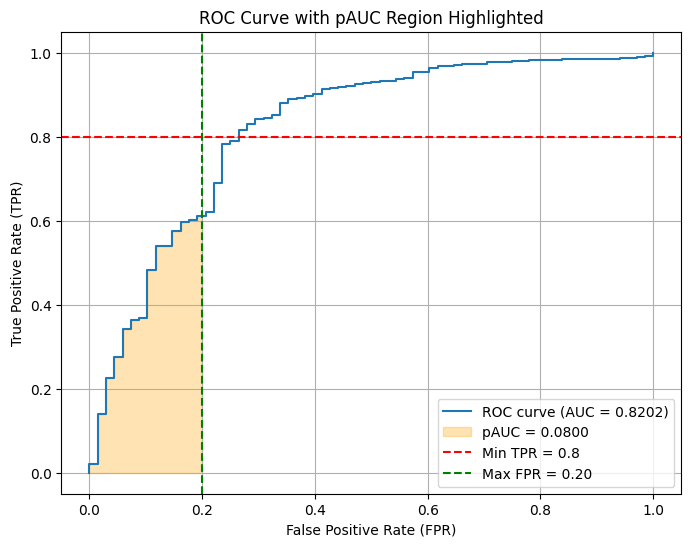

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_and_pauc(y_true, y_scores, min_tpr=0.80):
    # Flip labels and predictions (based on your scoring function)
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0 * np.asarray(y_scores)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(v_gt, v_pred)

    # Compute full AUC and partial AUC
    full_auc = auc(fpr, tpr)
    max_fpr = abs(1 - min_tpr)

    # Partial AUC calculation (manual interpolation for the cutoff point)
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    
    # Interpolated TPR at max_fpr
    interp_tpr = np.interp(max_fpr, x_interp, y_interp)
    
    # Create partial ROC arrays up to max_fpr
    pauc_fpr = np.append(fpr[:stop], max_fpr)
    pauc_tpr = np.append(tpr[:stop], interp_tpr)
    
    partial_auc = auc(pauc_fpr, pauc_tpr)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {full_auc:.4f})")
    
    # Shade pAUC region
    plt.fill_between(pauc_fpr, pauc_tpr, step="post", alpha=0.3, color="orange", label=f"pAUC = {partial_auc:.4f}")
    
    # Draw horizontal line at TPR = min_tpr
    plt.axhline(min_tpr, color='red', linestyle='--', label=f"Min TPR = {min_tpr}")

    # Draw vertical line at FPR = max_fpr
    plt.axvline(max_fpr, color='green', linestyle='--', label=f"Max FPR = {max_fpr:.2f}")

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve with pAUC Region Highlighted")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Example usage
plot_roc_and_pauc(all_labels, all_probs)

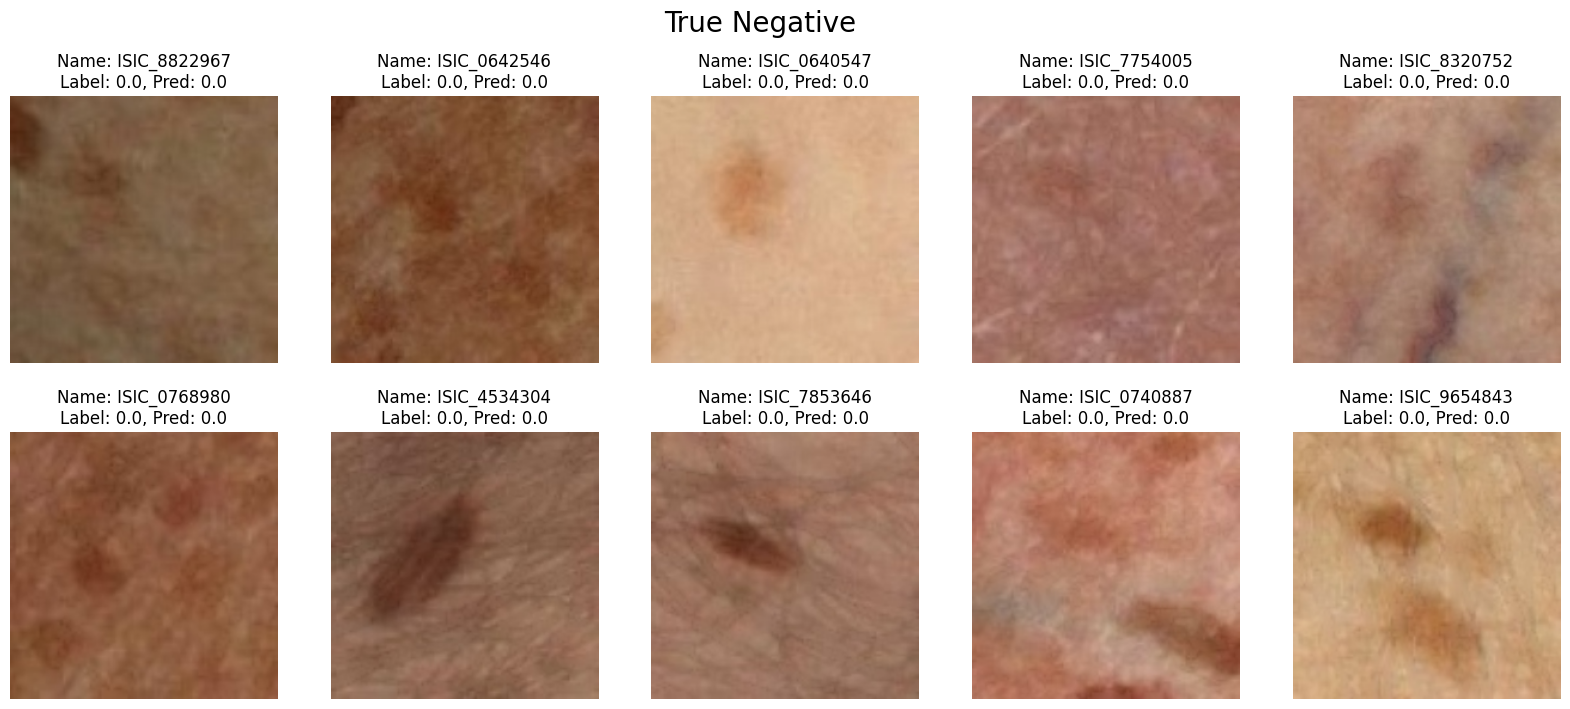

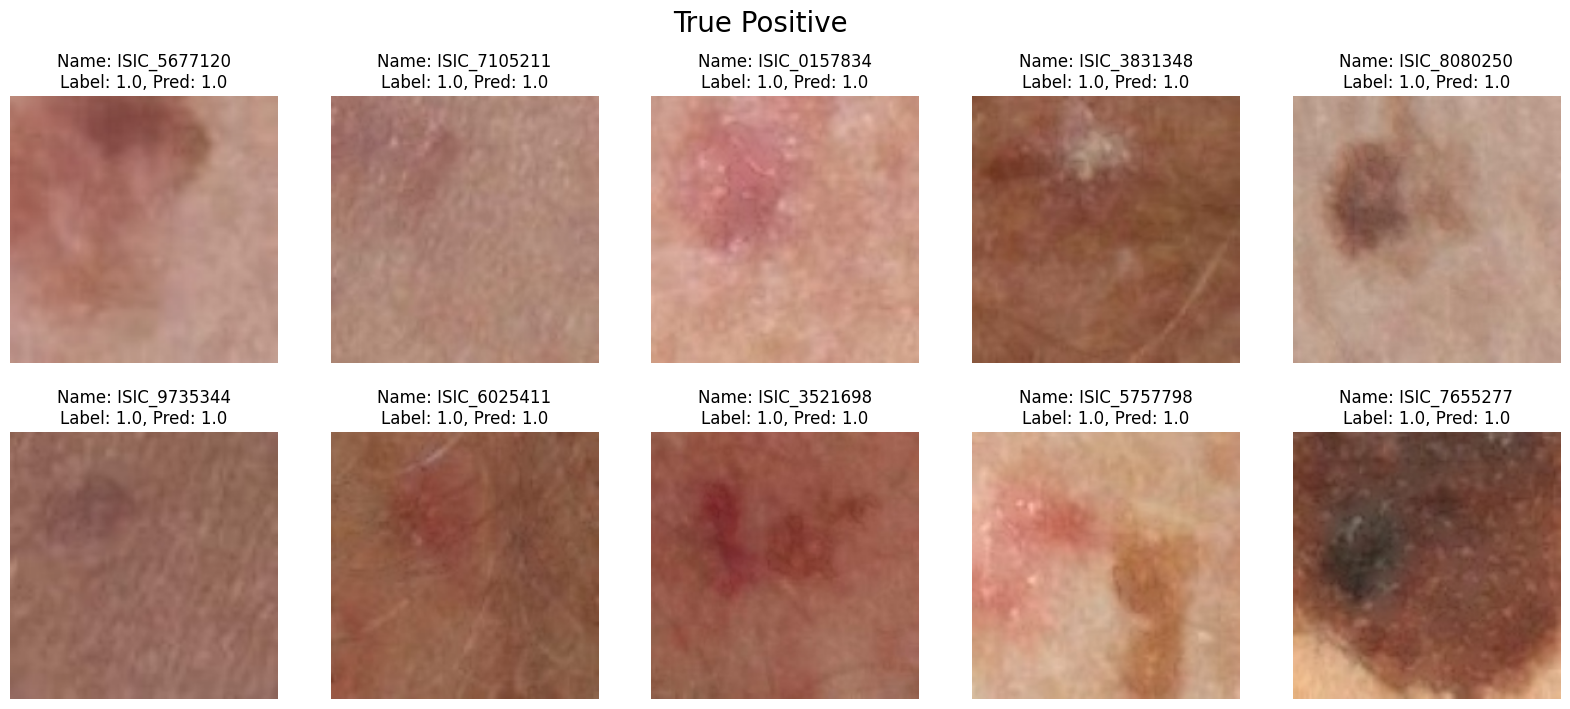

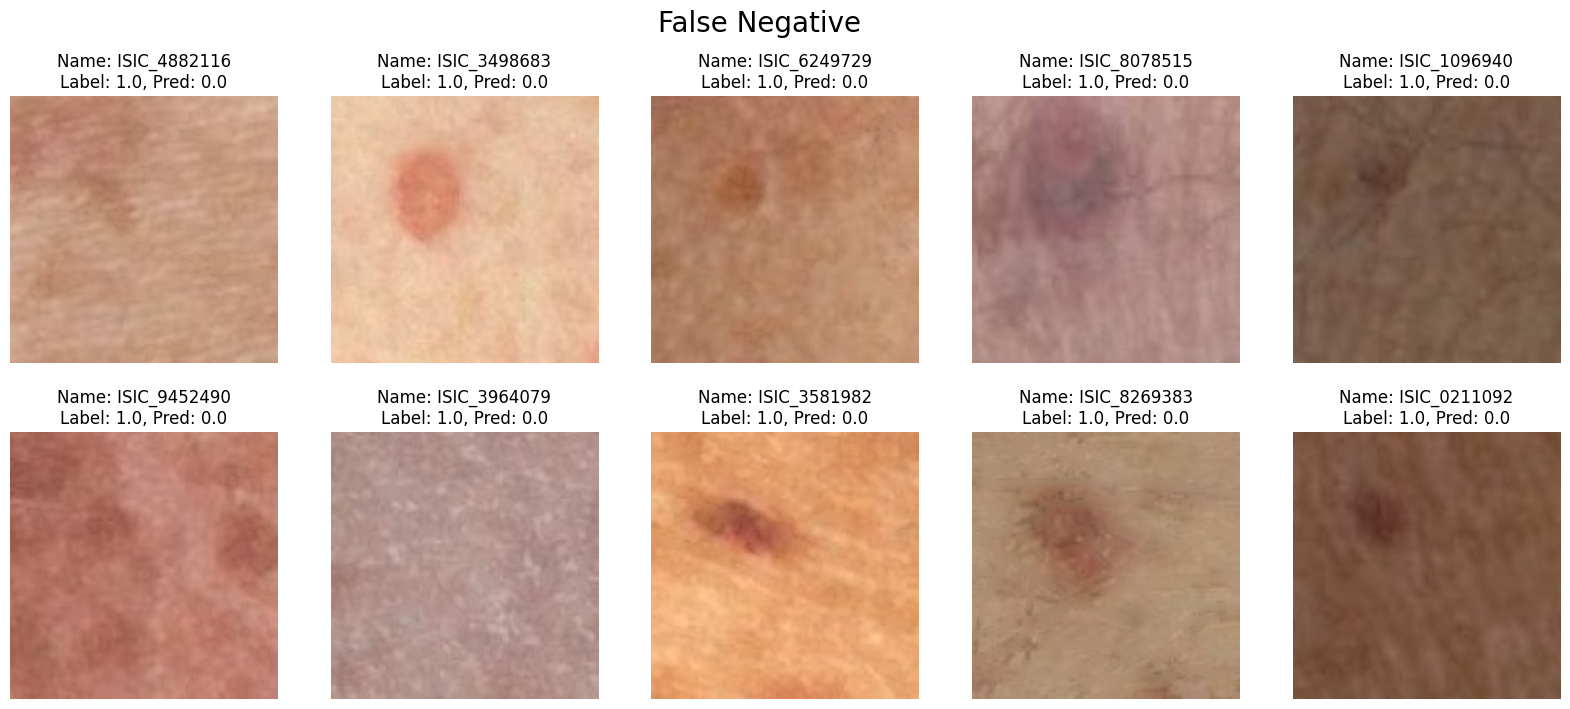

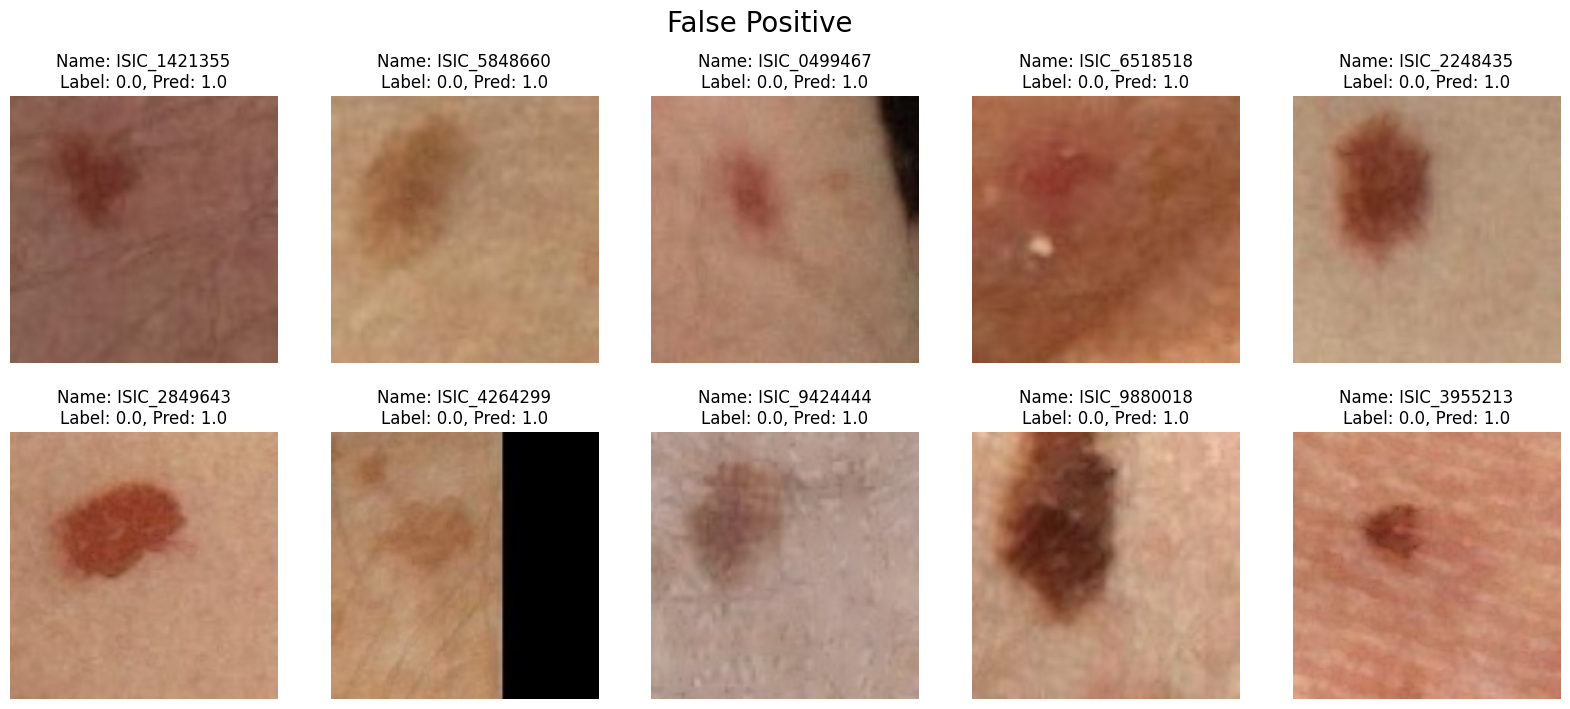

In [82]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Define the inverse normalization transformation
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

def display_images(images, labels, preds, names, title):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(title, fontsize=20)
    for i, (img, label, pred, name) in enumerate(zip(images, labels, preds, names)):
        ax = axes[i // 5, i % 5]
        img = inv_normalize(img)  # Undo normalization
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f"Name: {name}\nLabel: {label.item()}, Pred: {pred.item()}")
        ax.axis('off')
    # Hide any remaining subplots if there are fewer than 10 images
    for j in range(i + 1, 10):
        axes[j // 5, j % 5].axis('off')
    plt.show()

def get_images_by_type(dataloader, model, device, type, num_images=10):
    images, labels, preds, names = [], [], [], []
    model.eval()
    with torch.no_grad():
        for img_batch, label_batch, name_batch in dataloader:
            img_batch, label_batch = img_batch.to(device), label_batch.to(device).float().unsqueeze(1)
            output_batch = model(img_batch)
            pred_batch = torch.sigmoid(output_batch)
            pred_batch = (pred_batch > 0.5).float()
            for img, label, pred, name in zip(img_batch, label_batch, pred_batch, name_batch):
                if type == 'true_negative' and label == 0 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'true_positive' and label == 1 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_negative' and label == 1 and pred == 0:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                elif type == 'false_positive' and label == 0 and pred == 1:
                    images.append(img)
                    labels.append(label)
                    preds.append(pred)
                    names.append(name)
                if len(images) >= num_images:
                    return images, labels, preds, names
    return images, labels, preds, names

types = ['true_negative', 'true_positive', 'false_negative', 'false_positive']
for type in types:
    images, labels, preds, names = get_images_by_type(valloader, resnet, device, type)
    display_images(images, labels, preds, names, type.replace('_', ' ').title())